In [1]:
%load_ext autotime

import scarf
scarf.__version__

'0.19.0'

time: 1.36 s (started: 2021-09-28 22:03:45 +02:00)


# Some plotting functionality

## Scatter plots
This vignette will go through scarfs scatter plot functionality in more detail. The different topics are as follows:
* Basic plots
* Colored plots
* Grid plotting
* Shaded scatter plots for bigger datasets

## The most basic plot

First we will use CITE-Seq data from 10x genomics. This dataset contains two modalities: gene expression and surface protein abundance.

In [2]:
scarf.fetch_dataset('tenx_8K_pbmc_citeseq', save_path='scarf_datasets', as_zarr=True)

time: 12.8 s (started: 2021-09-28 17:33:24 +02:00)


In [2]:
ds = scarf.DataStore('scarf_datasets/tenx_8K_pbmc_citeseq/data.zarr')

time: 47 ms (started: 2021-09-28 22:03:46 +02:00)


time: 16 ms (started: 2021-09-29 14:33:20 +02:00)


In [14]:
ds.RNA

RNAassay RNA with 33538(33538) features

time: 0 ns (started: 2021-09-29 14:33:27 +02:00)


Minimum requirements to make a plot is to give the prefix for the cell metadata columns that contain the 2D coordinates. 

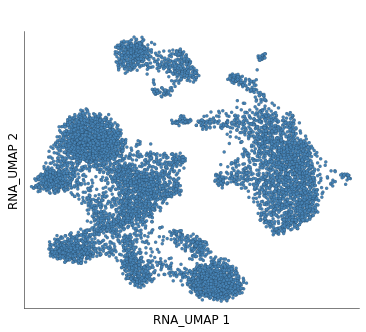

time: 766 ms (started: 2021-09-28 22:03:47 +02:00)


In [3]:
ds.plot_layout(layout_key='RNA_UMAP')

## Coloured plots

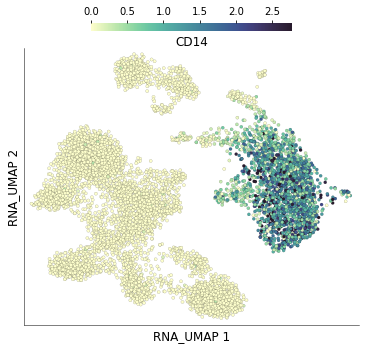

time: 687 ms (started: 2021-09-28 22:04:05 +02:00)


In [7]:
ds.plot_layout(layout_key='RNA_UMAP', color_by='CD14')

The default colormap is [cmocean.deep](https://matplotlib.org/cmocean/) and is changed with the `cmap` argument. 
In the example below we also set `spine_width=0` to remove the frames around the graph. 

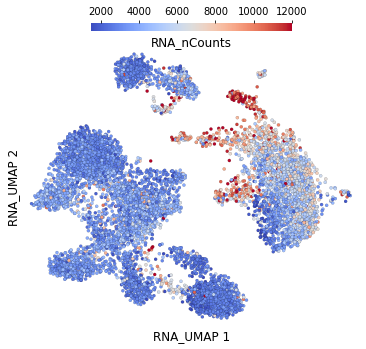

time: 641 ms (started: 2021-09-28 17:33:39 +02:00)


In [6]:
ds.plot_layout(layout_key='RNA_UMAP', color_by='RNA_nCounts', cmap="coolwarm", spine_width=0)

## Grid plotting
If you, instead of providing just one value in color_by, you give a list of values you will create a grid of plots. The number of grids per row is decided by the optional `n_columns` argument. If none is provided, as in the example below, then it will default to 4 columns per row (or less if you have less then 4 plots in total). 

In the example below we first plot the umap without any coloring by the empty string, then som numerical values such as a few different gene expressions and RNA_nCounts (total amount of features per cell) and lastly categorical cluster information.  

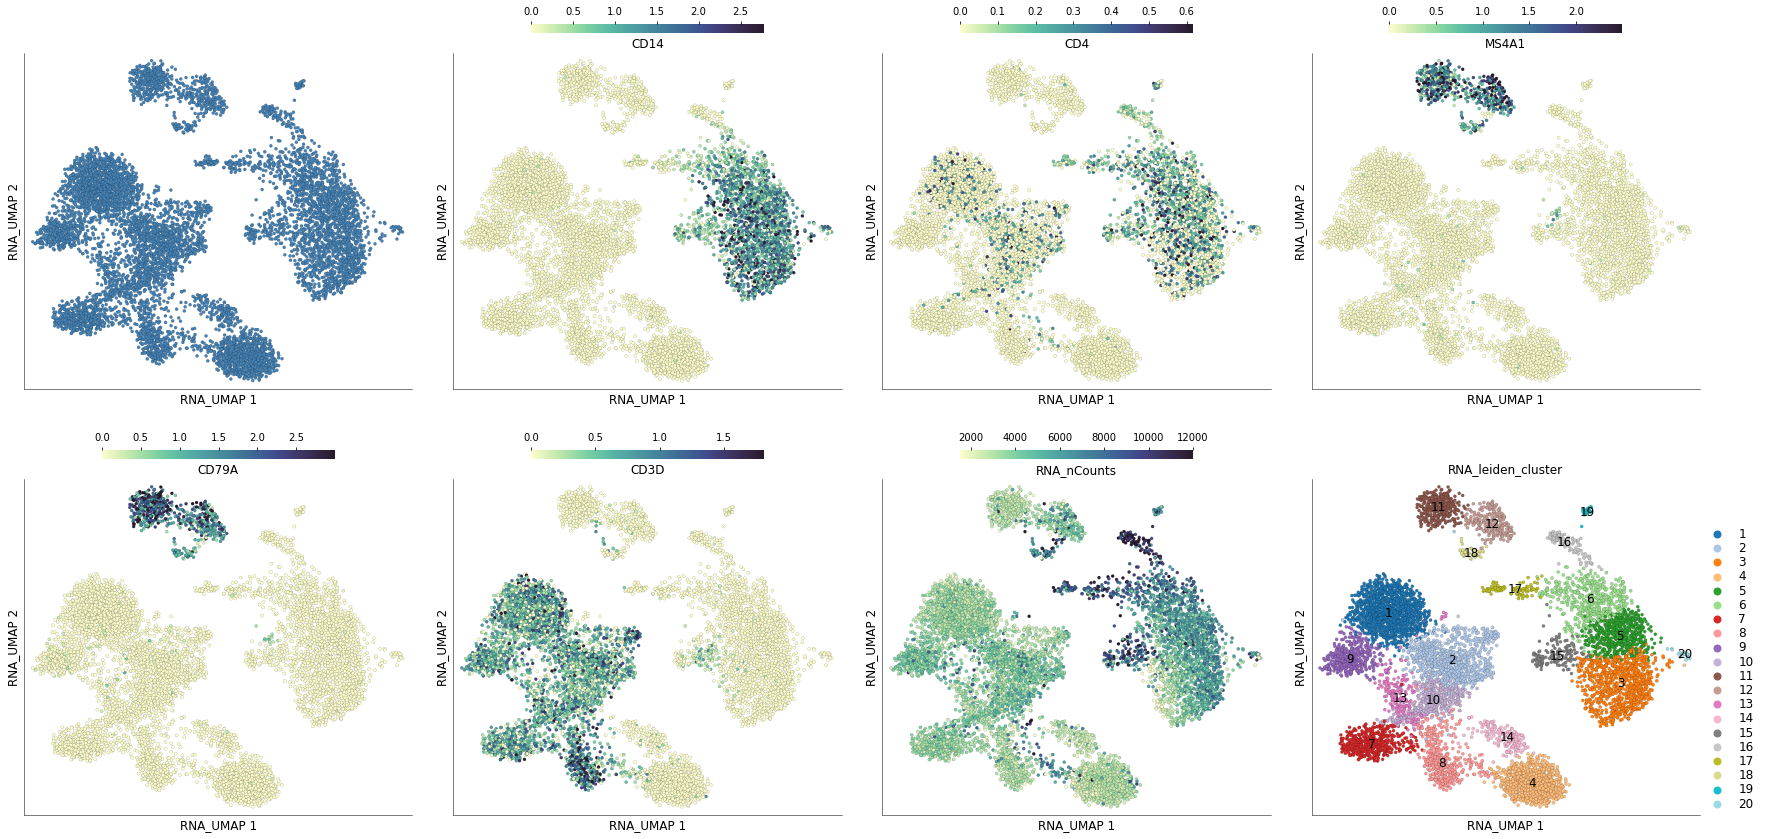

time: 4.61 s (started: 2021-09-28 22:04:14 +02:00)


In [8]:
ds.plot_layout(
    layout_key="RNA_UMAP",
    color_by=[
        "", "CD14", "CD4",
        "MS4A1", "CD79A", "CD3D",
        "RNA_nCounts", "RNA_leiden_cluster"
    ]
)

## Modifying the grid

### Padding
By default the padding between the plots will be automatically decided to avoid overlap. However, if you prefer to decide the padding yourself you can change it with `w_pad` and `h_pad`.

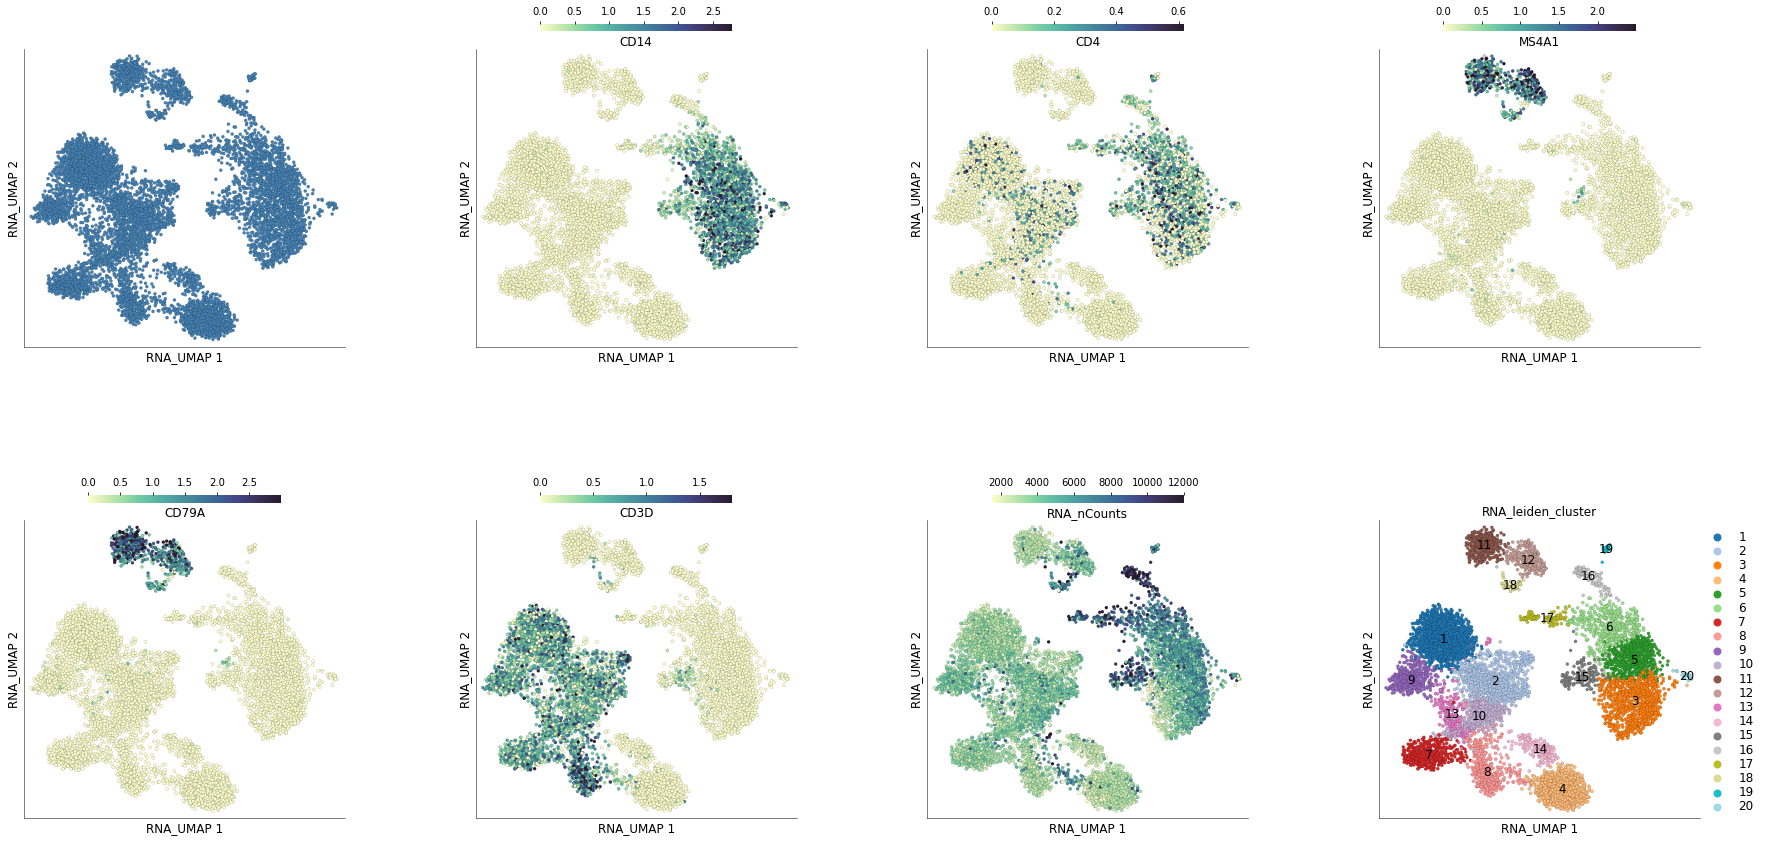

time: 4.56 s (started: 2021-09-28 17:35:21 +02:00)


In [12]:
ds.plot_layout(
    layout_key="RNA_UMAP",
    color_by=[
        "", "CD14", "CD4",
        "MS4A1", "CD79A", "CD3D",
        "RNA_nCounts", "RNA_leiden_cluster"
    ],
    w_pad=10,
    h_pad=10
)

### Plot different layouts
You can also give a list of values in the `layout_key` argument. This can be for example if you have calculated more then one set dimension reduction coordinates (UMAP and tSNE).
Or, as in the CITEseq dataset we use, if you multiple modalities. You can then plot multiple layouts if you have calculated one UMAP using the RNA data and one using the ADT (surface protein) data.

The function will go through each layout_key and for each value go through each value in the color_by. This means that if you give `layout_key=['key1', 'key2'], color_by=["gene1", "gene2"]` the order will be:
plot1 = key1 + gene1, plot2 = key1 + gene2, plot3 = key2 + gene1, plot3 = key2 + gene2

In the example below we also modify the width and height of the figure. The `width` and `height` arguments are per plot which means that if you create a grid plot the total width will be `width` * `n_columns` and the total height will be `height` * number of rows.
We will also increase the size of some other things to go along with the increased width and height.

Using the `legend_size` you can increase the size of the cluster legend and labels on top of the graph, default value is 12.

`point_size` will, as you might have guessed, increase the size of each point. It defaults to 10. 

`marker_scale` will increase the colored legend markers. 

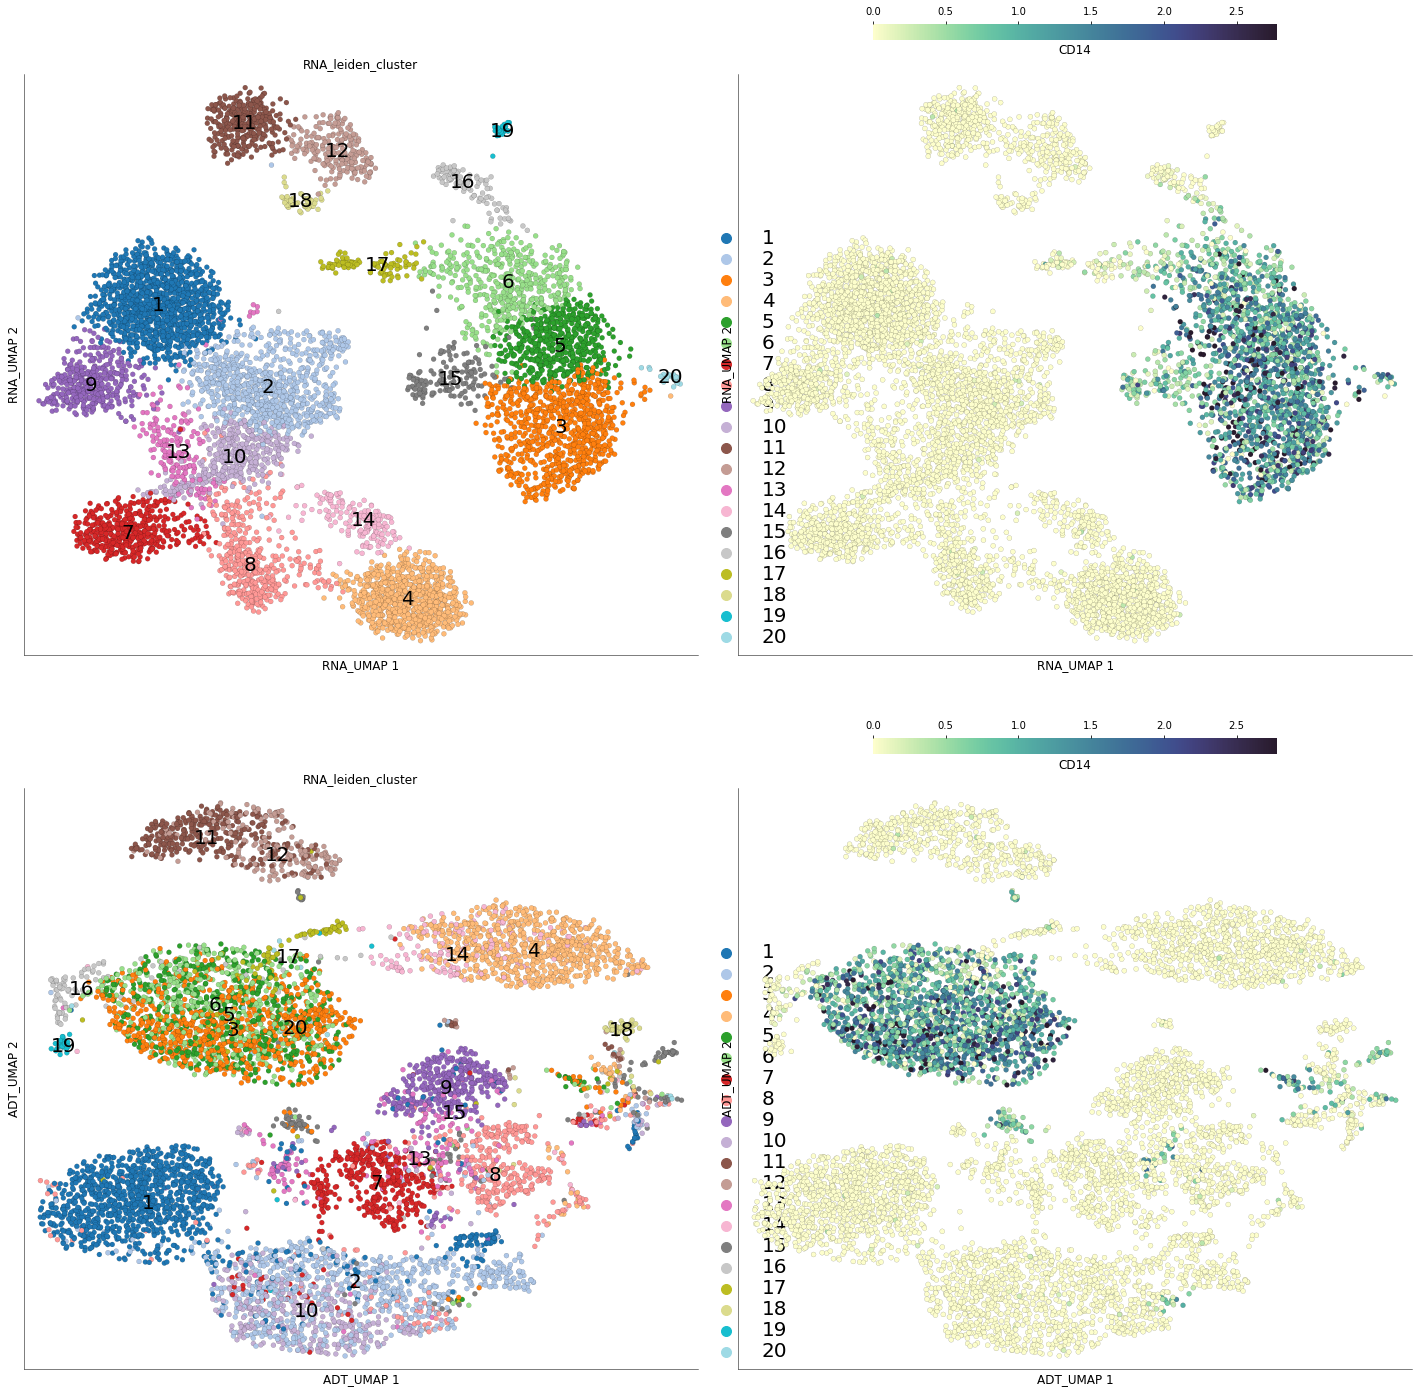

time: 2.64 s (started: 2021-09-28 17:33:49 +02:00)


In [9]:
ds.plot_layout(
    layout_key=["RNA_UMAP", "ADT_UMAP"],
    color_by=["RNA_leiden_cluster", "CD14"],
    n_columns=2,
    width=10,
    height=10,
    legend_size=20,
    point_size=25,
    marker_scale=100
)

## Shaded scatter plots for larger datasets
Plotting for larger datasets can a lot of times lead to some problems. One such issue is **overplotting**, which refers to that some points will be plotted on top of others. This can happend in smaller datasets as well if the graph contains densely packed clusters, but is much more of an issue in larger ones because it will likely be more densely packed. In the example below you can see that this is happening even if we turn down the point size to 5. In the example below you can see is hard to discern where the more dense populations of cells are located as well as when coloring by a gene expression some of the colored points can become hidden behind non-colored.

To properly demonstrate the value of using shaded scatter plots we will need a bigger dataset. For this we will use the hca_783K_blood_rnaseq dataset (which you can download via the `fetch_dataset` function. This dataset takes longer to preprocess and to calculate the UMAP for. For the purpose of this vignette we will instead show the results as pre rendered images.

In [ ]:
#ds = scarf.DataStore('D:/scarf_datasets/hca_783K_blood_rnaseq.zarr') # preprocessed data
#ds.plot_layout(layout_key=['RNA_UMAP'], color_by=['', 'CD14'], point_size=5, savename="hca_783K_blood_rnaseq_normalscatter")

# Non scarf code to show the pre rendered images
# import matplotlib.image as mpimg
# import matplotlib.pyplot as plt

# fig = plt.figure(figsize=[14, 14], facecolor='white')
# fig.gca().axis('off')
# img = mpimg.imread('hca_783K_blood_rnaseq_normalscatter.png')
# fig = plt.imshow(img)

To avoid the problem of overplotting and other issues that come with larger dataset sizes scarf uses the datashader library. A shaded scatter plot is created by setting `do_shading=True` which otherwise defaults to False.
Read more in depth about problems that can occur when plotting and how the datashader deals with them read here: [Plotting Pitfalls](https://datashader.org/user_guide/Plotting_Pitfalls.html)

The `shade_npixels` decides the resolution of the output image (width and height). 
These shaded scatter plots can be grid plotted just as the normal scatter plots.

In [11]:
#ds.plot_layout(layout_key=['RNA_UMAP'], color_by=['', 'CD14'], shade_npixels=700, do_shading=True, savename="hca_783K_blood_rnaseq_shadedscatter")

# Non scarf code to show the pre rendered images
# fig = plt.figure(figsize=[14, 14], facecolor='white')
# fig.gca().axis('off')
# img = mpimg.imread('hca_783K_blood_rnaseq_shadedscatter.png')
# fig = plt.imshow(img)

time: 0 ns (started: 2021-09-28 17:33:52 +02:00)
